2023-12-30 01:07:05.120116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 01:07:05.120184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 01:07:05.146489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 01:07:05.153825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 01:07:06.323319: W tensorflow/compiler/tf2tens

###################################################################1
###################################################################2


2023-12-30 01:07:08.490759: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-12-30 01:07:08.719103: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


###################################################################3
tf.Tensor([[-0.00266082]], shape=(1, 1), dtype=float32)
###################################################################4
###################################################################5
###################################################################6
0
Epoch 1
plotting


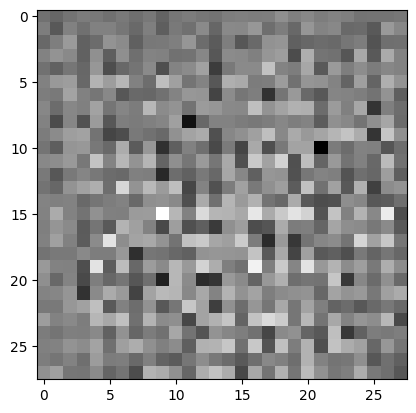

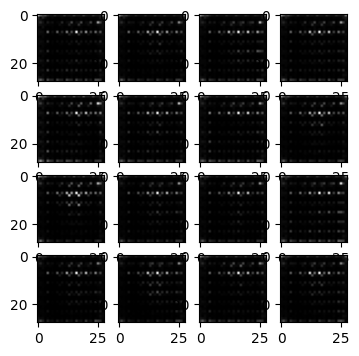

1
2
Epoch 3
plotting


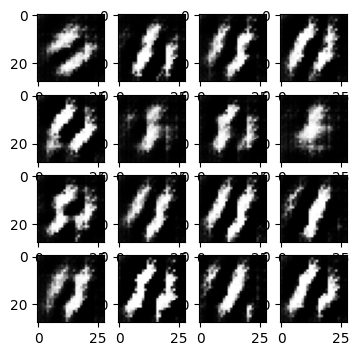

3
4
Epoch 5
plotting


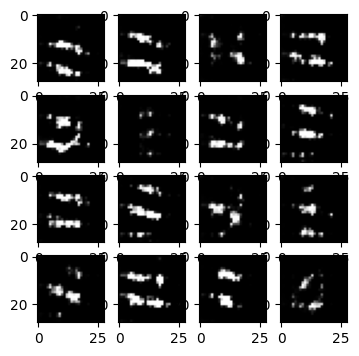

5
6
Epoch 7
plotting


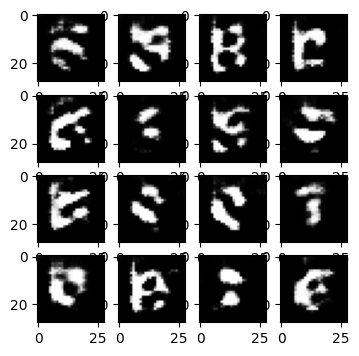

7
8
Epoch 9
plotting


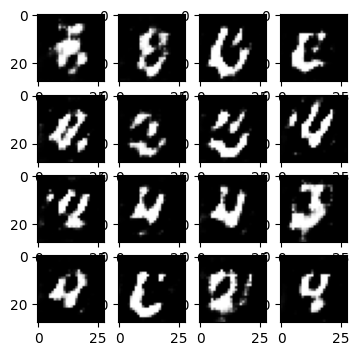

9


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
import matplotlib.pyplot as plt


print("###################################################################1")   
def fun_descr():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model
    
def fun_gen():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias = False, input_shape = (100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides = (2,2 ), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model
    
def plot_gen_img(model, epoch, tinput):
    print('plotting')
    predictions = model(tinput, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') 
    plt.show()
print("###################################################################2")   
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
buf1= 28
buf2 = 28
buf3 = 1
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5
set_for_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(256)
fun_gen = fun_gen()
print("###################################################################3")   
noise = tf.random.normal([1, 100])
gen_img = fun_gen(noise, training = False)

plt.imshow(gen_img[0,:,:,0], cmap = 'gray')

fun_descr = fun_descr()

decision = fun_descr(gen_img)

print(decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
print("###################################################################4")   
def disc_loss(true_output, fake_output): 
    loss = cross_entropy(tf.ones_like(true_output), true_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    return loss

def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
seed = tf.random.normal([16, 100])

print("###################################################################5")   
@tf.function
def trainings(images):
    #print("A1")
    noise = tf.random.normal([256, 100])
    #print("A")
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        gen_img = fun_gen(noise, training = True)
        #print("D")
        generator_loss = gen_loss(fun_descr(gen_img, training = True))
        #print("f")
        discriminator_loss = disc_loss(fun_descr(images, training = True), fun_descr(gen_img, training = True))
        #print("G")
    grad_generator = generator_tape.gradient(generator_loss, fun_gen.trainable_variables)
    grad_discriminator = discriminator_tape.gradient(discriminator_loss, fun_descr.trainable_variables)
    #print("H")
    generator_optimizer.apply_gradients(zip(grad_generator, fun_gen.trainable_variables))
    #print("K")
    discriminator_optimizer.apply_gradients(zip(grad_discriminator, fun_descr.trainable_variables))
    #print("L")




print("###################################################################6")   

def train(ds, epochs):
    for epoch in range(epochs):
        print(epoch)
        for img_batch in ds:
       #     print('enter')
            trainings(img_batch)
      #      print(    'exit')
        if epoch % 2 == 0:
            print(f"Epoch {epoch+1}")
            plot_gen_img(fun_gen, epoch + 1, seed)
train(set_for_train, 100)
#train(set_for_train , 100)
#?????????????


